# Qiskit Notebook 7 - Variational Quantum Algorithms


In this Notebook, we will learn about:

* Variational Principle
* Variational Quantum Algorithms (VQA) and its main components
* Variational Quantum Eigensolver (VQE)

In [ ]:
# If using Google Colab, uncomment the following

#!pip install -q qiskit
#!pip install -q qiskit[visualization]
#!pip install -q qiskit-ibm-runtime
#!pip install -q qiskit-aer
#!pip install -q qiskit-nature

In the previous Notebooks, we studied two examples of quantum algorithms (Grover's algorithm and QPE/Shor's algorithm) with provable quantum advantage in time complexity when compared to its classical counterparts. As mentioned before, this algorithms fall into the set of **Fault-Tolerant Quantum Algorithms** (FTQA), which in practice require huge amounts of logical qubits (i.e. qubits without errors) and noiseless quantum gates and measurement operations. Currently available hardware, like IBMs and Google's quantum computers, fall into the set of **Noisy Intermediate-scale Quantum** (NISQ) computers, coined by John Preskill in [2018](https://arxiv.org/abs/1801.00862), which are characterized by:

* Having a low number of noisy qubits (up to the order of $1000$ qubits).
* Limited connectivity (and entanglement) between qubits.
* Noisy quantum operations (Gates and Measurements).
* Short coherence times.
* Low quantum circuit depth.

Because of the previous limitations, most quantum machines are not capable (for example) of performing **Quantum Error Correction** (QEC), a necessary tool for obtaining logical (error-free) qubits for performing fault-tolerant computation. To tackle this limitations, **Variational Quantum Algorithms** (VQA) correspond to the most promising strategy for observing quantum computation utility using near-term NISQ devices. VQAs correspond to **hybrid classical-quantum** algorithms, that combine the power of classical optimization methods with cost functions obtained through the computation of "hard-to-obtain quantities" calculated in a quantum device.

![Fig1_Map[1]-1.png](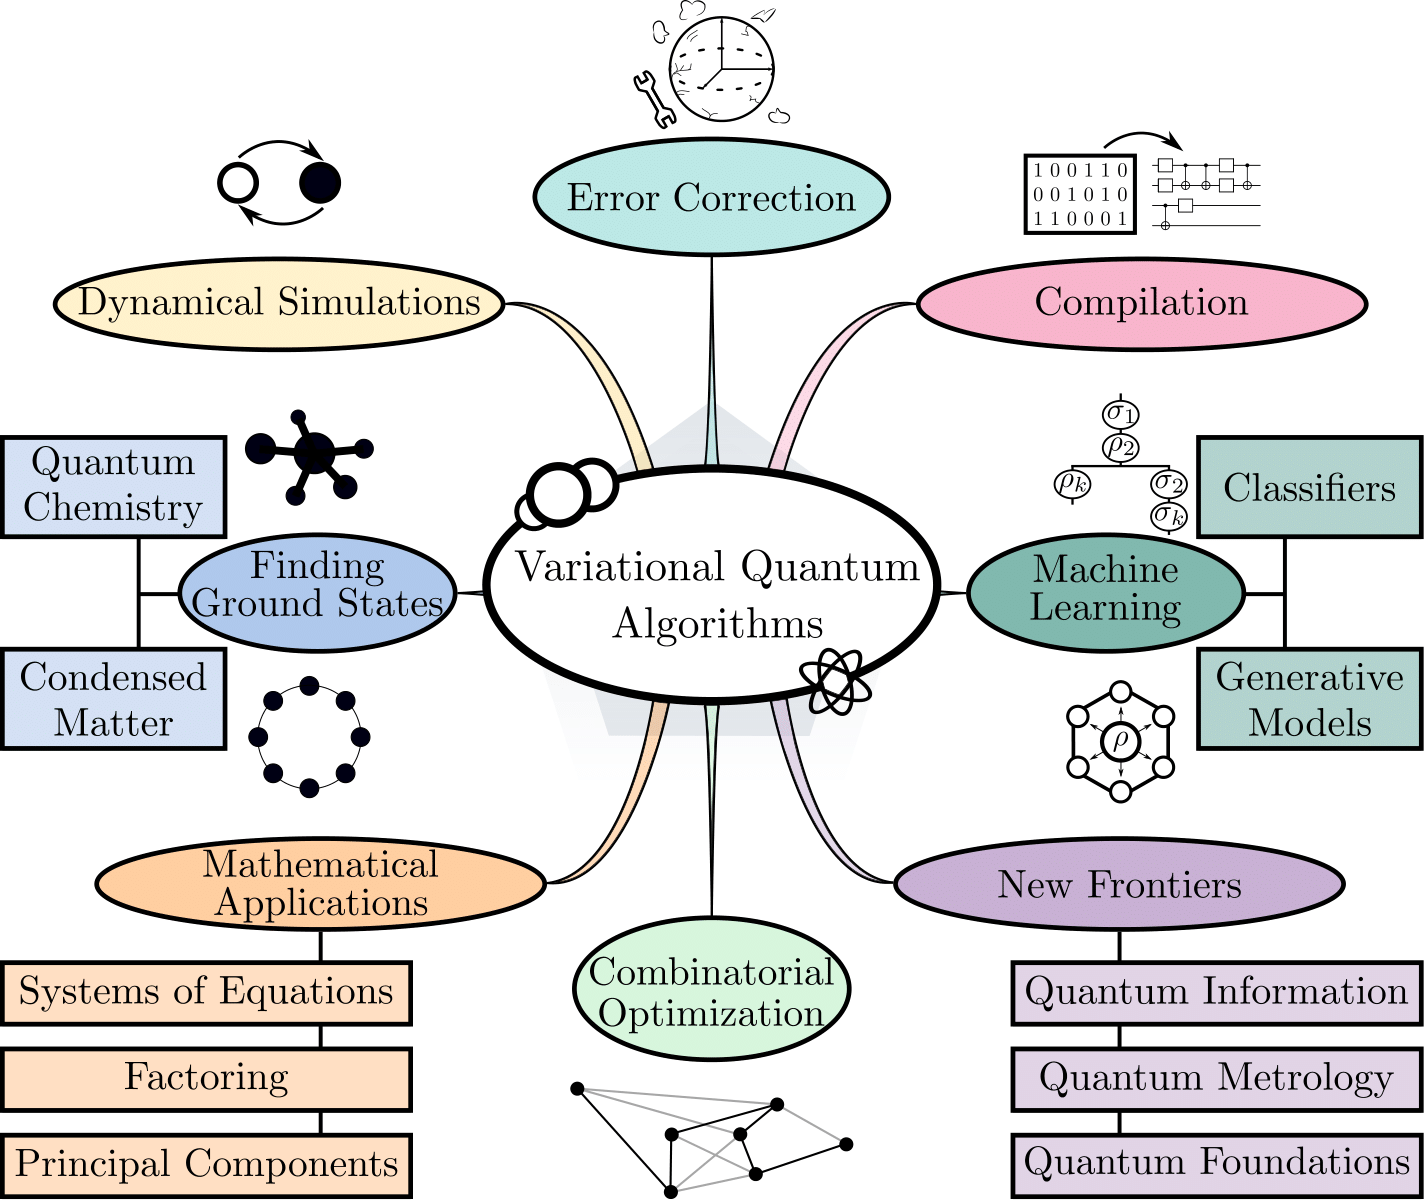)

Source: [Variational Quantum Algorithms (2020)](https://arxiv.org/abs/2012.09265)

Variational Quantum Algorithms consist of three main steps:


* A **cost function** $C(\boldsymbol{\theta})$, which codifies the solution of our problem.
* A (parametric) quantum circuit that prepares the state that best meets the problem’s objective called **ansatz** state $|\psi (\boldsymbol{\theta})\rangle$, which depends on the set of parameters $\boldsymbol{\theta}$.
* A **classical optimization algorithm**, which aims to solve the optimization task $\boldsymbol{\theta}^{*}=\underset{\boldsymbol{\theta}}{\arg \min } \ C(\boldsymbol{\theta})$.


## Variational Principle

In general, the main goal of variational algorithms is to find the quantum state with the lowest (highest) eigenvalue of a certain observable, which correspond to obtaining the solution to our task at hand (up to some extra classical post-processing tasks). VQAs rely on the **variational method** in quantum mechanics to obtain approximates of the smallest eigenvalue of a Hamiltonian.

As mentioned in the previous Notebook, the **Hamiltonian** $H$ corresponds to a quantum observable which represents the total energy of a quantum system. This Hamiltonian can be written, for example, as a matrix, or as mentioned before, as a sum of tensor products of **Pauli operators**, that is,

$$
H=\sum_{k=1}^{K} \alpha_{k} P_{k}, \, \, \, P_{k} \in\{I, X, Y, Z \}^{\otimes n}, \, \, \, \alpha_{k} \in\mathbb{R}, 
$$

Another way of representing the Hamiltonian is through its **spectral decomposition**, that is, as a sum of its eigenvalues $\{\lambda_k\}$ and eigenvectors $\{|\phi_k\rangle\}$

$$
H=\sum_{k=1}^{N-1} \lambda_k |\phi_k\rangle\langle\phi_k|, 
$$

where $N$ is the dimension of the Hilbert space (for our purposes, of the vector space), and $\lambda_k$ corresponds to the $k$-th eigenvalue. Physically speaking, the eigenvalues of the (quantum) Hamiltonian corresponds to the **energy levels** of the system. As $|\phi_k\rangle$ correspond to an eigenstate of the Hamiltonian, they satisfy

$$
H |\phi_k\rangle\ = \lambda_k |\phi_k\rangle.
$$

The expected energy of a system in the state $|\psi\rangle$, that is, the **expectation value** of $H$ in the state $|\psi \rangle$ is then given by:

$$
\langle\psi| H |\psi\rangle = \langle\psi| \left(\sum_{k=1}^{N-1} \lambda_k |\phi_k\rangle\ \langle\phi_k| \right) |\psi\rangle = \sum_{k=1}^{N-1} \lambda_k |\langle\psi |\phi_k\rangle|^2
$$

As the Hamiltonian corresponds to an Hermitian operator, all of its eigenvalues are positive. Let $\lambda_0 \leq \lambda_k \forall k$ denote the smallest eigenvalue, then

$$
\langle\psi| H |\psi\rangle = \sum_{k=1}^{N-1} \lambda_k |\langle\psi |\phi_k\rangle|^2 \geq \sum_{k=1}^{N-1} \lambda_0 |\langle\psi |\phi_k\rangle|^2 = \lambda_0 \sum_{k=1}^{N-1} |\langle\psi |\phi_k\rangle|^2 = \lambda_0,
$$
where we used the fact that $\{|\phi_k\rangle\}$ is an orthonormal basis and $|\langle\psi |\phi_k\rangle|^2$ corresponds to the probability of measuring the state $|\phi_k\rangle$, so $\sum_{k=1}^{N-1} |\langle\psi |\phi_k\rangle|^2 = \sum_{k=1}^{N-1} p_k = 1$.

Therefore, we will have that, for any valid quantum state $|\psi\rangle$, it follows that $\langle\psi| H |\psi\rangle \geq \lambda_0 $. We can therefore consider a parametrized state $|\psi (\boldsymbol{\theta})\rangle$, which depends on a set of parameters $\boldsymbol{\theta}$. If we can calculate the smallest eigenvalue by solving the optimization problem given by

$$
\min_{\boldsymbol{\theta}} \langle\psi(\boldsymbol{\theta})| H |\psi(\boldsymbol{\theta})\rangle \geq \lambda_0.
$$

The equality will only be reached if there **exists** a set of parameters $\boldsymbol{\theta^*}$ such that $|\psi (\boldsymbol{\theta^*})\rangle = |\phi_0\rangle.$

## Ansatz

In physics and mathematics, the german word *Ansatz*, or in plural *Ansätze*, refers to guessing a solution. In the context of VQAs, the ansatz correspond to a parametric quantum circuit given by

$$
|\psi (\boldsymbol{\theta})\rangle = U(\boldsymbol{\theta}) |\psi_0\rangle,
$$

where $U(\boldsymbol{\theta})$ is a parameterized unitary operation (composed of quantum gates) and $|\psi_0\rangle$ is some intial state, which typically correspond to a product state with all qubits in the ground state, i.e. $|000 \ldots 0\rangle = |0\rangle^{\otimes n}$, where $n$ is the number of qubits.

For an $n$-qubit quantum state, the dimension of the Hilbert space grows exponentially $d = 2^{2n}$, in other words, we would require an exponential number of parameters to fully explore the space of all possible states where the solution lives. To counter this setback, it is common practice to impose some reasonable constraints on the variational form such that only the most relevant states are explored. Two groups of ansätze are:

* **Heuristic ansätze**, which correspond to arbitrary families of parameterized circuits with fewer than $d$ parameters. One subgroup of these are the **Hardware-efficient ansätze**, which are constructed taking into consideration a limited set of quantum gates and a particular qubit connection topology, such that it is ad-hoc to the available quantum device.
* **Problem-inspired ansätze**, which employ known information about the underlying structure/physics of the problem to restrict our circuit search space.

Lets consider the following two examples:

* [Real-amplitudes 2-local circuit](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.real_amplitudes), which corresponds to an heuristic ansatz used in chemistry, optimization or machine learning applications. This circuit is called “real amplitudes” since the prepared quantum states will only have real amplitudes.
* [Unitary Coupled-Cluster Ansatz](https://qiskit-community.github.io/qiskit-nature/stubs/qiskit_nature.second_q.circuit.library.UCC.html#qiskit_nature.second_q.circuit.library.UCC), commonly used in quantum chemistry for studying the electronic structure of molecular Hamiltonians. 

Observation: To obtain the UCC ansatz circuit, we will use the `qiskit-nature` open-source framework. Notice that the latest version $(0.7.2)$ is currently incompatible with the newest `qiskit` version $(2.0.0)$.


Gates: {'ry': 16, 'cx': 9}
Number of parameters: 16


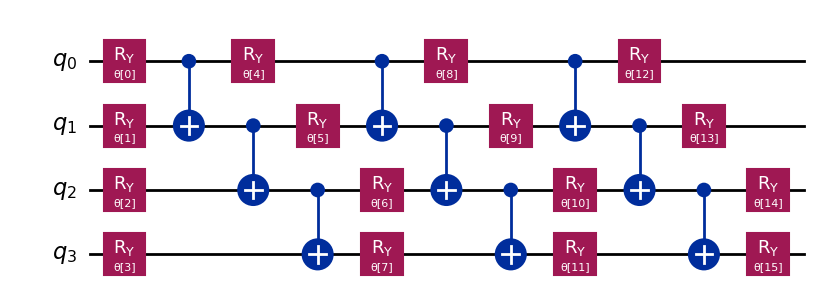

In [4]:
# Real Amplitudes Ansatz for four qubits with two repetitions

from qiskit.circuit.library import real_amplitudes

he_ansatz = real_amplitudes(num_qubits=4, reps=3, entanglement='linear')
print(f'Gates: {dict(he_ansatz.count_ops())}')
print(f'Number of parameters: {he_ansatz.num_parameters}')
he_ansatz.draw('mpl')

In [8]:
# The Jordan-Wigner fermion-to-qubit mapping

from qiskit_nature.second_q.mappers import JordanWignerMapper
qubit_mapper = JordanWignerMapper()

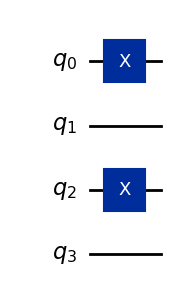

In [6]:
# Hartree-Fock initial state

from qiskit_nature.second_q.circuit.library import HartreeFock

HartreeFock_init = HartreeFock(num_spatial_orbitals = 2, num_particles=(1,1), qubit_mapper=qubit_mapper)
HartreeFock_init.draw('mpl')

Gates: {'cx': 56, 'h': 40, 'sx': 20, 'sxdg': 20, 'rz': 12}
Number of parameters: 3


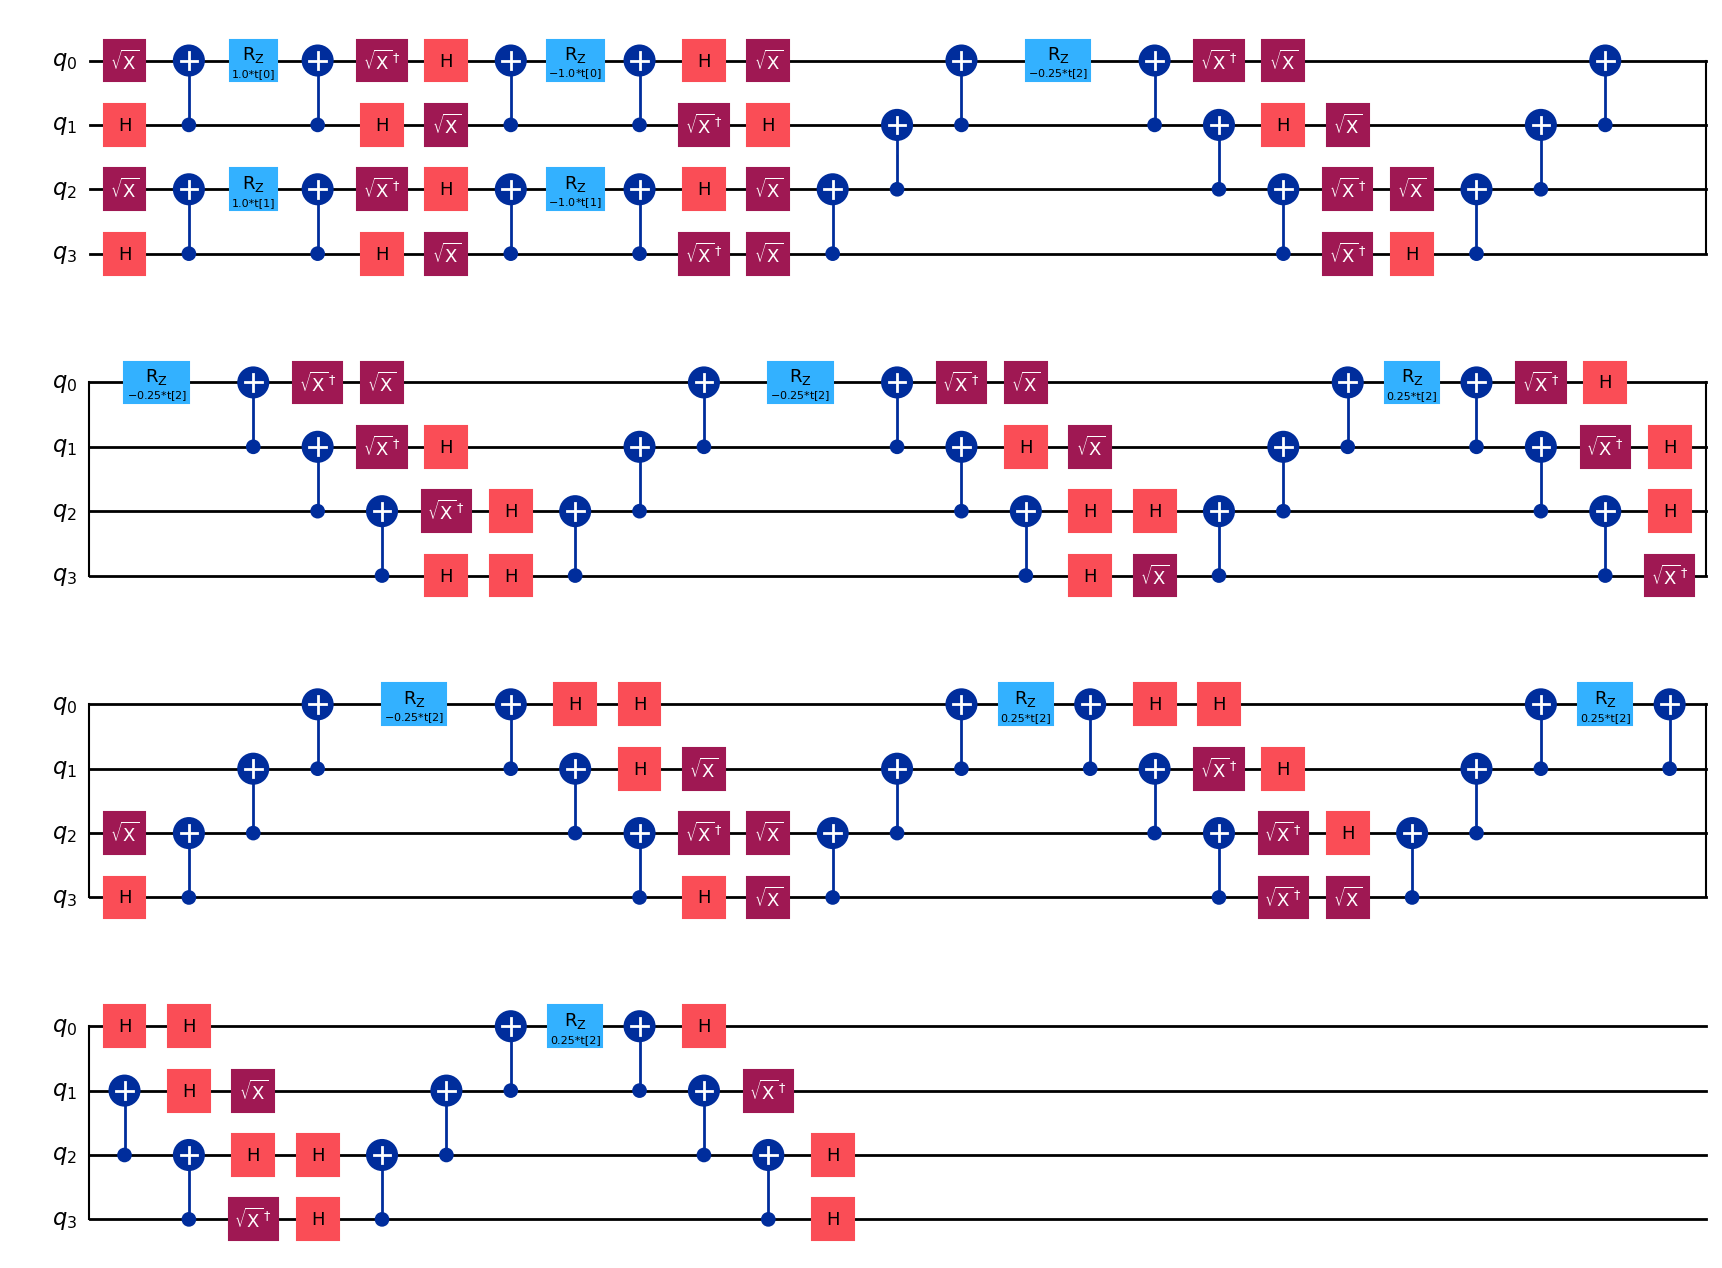

In [9]:
# UCC Ansatz for two spatial orbitals and (1,1) alpha and beta excitations, with single and double excitations

from qiskit_nature.second_q.circuit.library import UCC

reps = 2

ucc = UCC(2, (1, 1), 'sd', qubit_mapper=qubit_mapper)

print(f'Gates: {dict(ucc.decompose(reps=reps).count_ops())}')
print(f'Number of parameters: {ucc.num_parameters}')
ucc.decompose(reps=reps).draw('mpl')

There are two key points one must consider when analyzing how good an ansatz is for solving an specific problem:

* **Expressibility**, which quantifies the range of functions that the quantum circuit can describe, and it is closely related to the amount of parameters and entanglement gates that the ansatz has. High expressibility implies a higher accuracy.

* **Trainability**, which quantifies how difficult it is for the optimizer to find the correct set of parameters that solve our problem. High trainability implies a higher optimization speed.

Usually, there's a trade-off expressibility and trainability: The larger and more expressive circuits are, the harder it is to train them. Trainability also depends on the choice of the cost function and the optimizer.

## Cost Function

In general, **cost functions** are used to describe the goal of a problem and how well a trial (ansatz) state is performing with respect to that goal. In VQAs, we define the cost function as the expectation value of a given Hamiltonian $H$ with a given ansatz state $|\psi(\boldsymbol{\theta})\rangle$:

$$
C(\boldsymbol{\theta}) = \langle\psi(\boldsymbol{\theta})| H |\psi(\boldsymbol{\theta})\rangle = \langle\psi_0 | U^{\dagger}(\boldsymbol{\theta}) H U(\boldsymbol{\theta})|\psi_0 \rangle.
$$

For a VQA to truly have a real advantage over classical alternatives, the cost function must satisfy the [following criteria](https://arxiv.org/abs/2012.09265).

* The minimum of C(θ) must correspond to the solution of the problem **(Faithfulness)**.
* It must be able to eﬃciently estimate the cost using a quantum computer and possibly perform classical post-processing, under the assumption that such cost should not be easily computable using classical hardware (**Efficient Estimation)**.
* The lower values of the cost indicate a better solutions **(Operationally Meaningful)**.
* The cost function needs to be trainable, meaning that it is possible to optimize eﬃciently the parameters $\boldsymbol{\theta}$ in a suitable computation time lapse **(Trainability)**.

## Classical Optimization

Once the ansatz and cost function are extablished, the next step is to define an optimal classical optimization routine to train the parameters. The optimizer uses cost function evaluations to select the next set of parameters in a variational loop, and repeats the process until it reaches a (hopefully) optimal solution, that is, obtain the set of parameters that satisfy

$$
\boldsymbol{\theta}^{*}=\underset{\boldsymbol{\theta}}{\arg \min } \ C(\boldsymbol{\theta}).
$$

In general, the classical optimization methods used for VQAs can be separated into two classes:

* **Gradient-Based** methods.
* **Gradient-Free** methods.

In gradient based methods, the gradient (or an approximation) of the cost function $\Delta C(\boldsymbol{\theta})$ is calculated starting from the initial point $\boldsymbol{\theta}_0$, and the parameters at iteration $k+1$ are updated following the direction of steepest descent of the function:

$$ \boldsymbol{\theta}_{k+1} = \boldsymbol{\theta}_k - \eta  \Delta C(\boldsymbol{\theta}),$$

where $\eta$ is a hyperparameter known as the learning rate, which controls the size of the update. This parameters update continues until the we converge to a local minimum of the cost function.


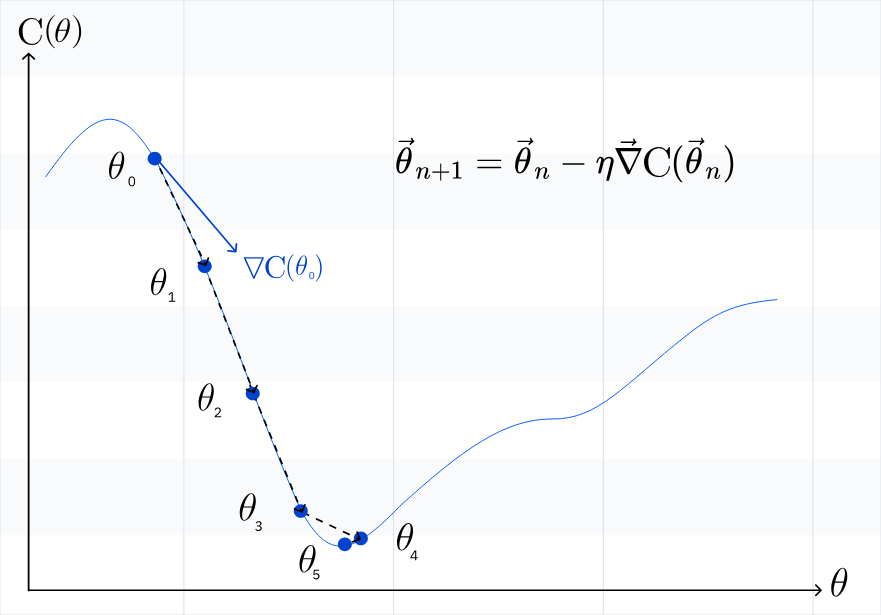

Gradient-free optimization algorithms do not require gradient information and can be useful in situations where computing the gradient is difficult, expensive, or too noisy. They also tend to be more robust in finding global optima, whereas gradient-based methods tend to converge to local optima. However, gradient-free methods require higher computational resources, especially for problems with high-dimensional search spaces.

When choosing an optimizer, it is important to consider the following facts:

* To calculate the expectation value of a given Hamiltonian, we have to first decompose it in terms of Pauli Operators. Therefore, we have to measure each Pauli operator (which corresponds to measuring a circuit with a given number of shots). An eﬀective optimizer should try to **minimize the number of shots and/or the cost function evaluations** needed to converge to the optimal value.

$$
C(\boldsymbol{\theta_k}) \rightarrow \langle \psi (\boldsymbol{\theta_k}) | H | \psi (\boldsymbol{\theta_k}) \rangle \rightarrow \sum_{k=1}^{K} \alpha_{k} \langle \psi (\boldsymbol{\theta_k}) | P_{k} | \psi (\boldsymbol{\theta_k}) \rangle
$$


* A limited limited number of shots in the measurement introduce statistical errors (that is, if the expectation value of Pauli operator $P_k$ is low, then we need a huge a number of shots to effectively compute it). If we also include the fact that NISQ computers have high amounts of noise sources, then the optimizer must be highly **resilient to noise**.


Examples of classical optimization methods can be found within the `scipy.optimize` [library](https://docs.scipy.org/doc/scipy/reference/optimize.html), or for cases closely related to VQAs, within the `qiskit-algorithms` [library](https://qiskit-community.github.io/qiskit-algorithms/apidocs/qiskit_algorithms.optimizers.html#module-qiskit_algorithms.optimizers) of `Optimizers`.

![VQA_loop[1]-1.png](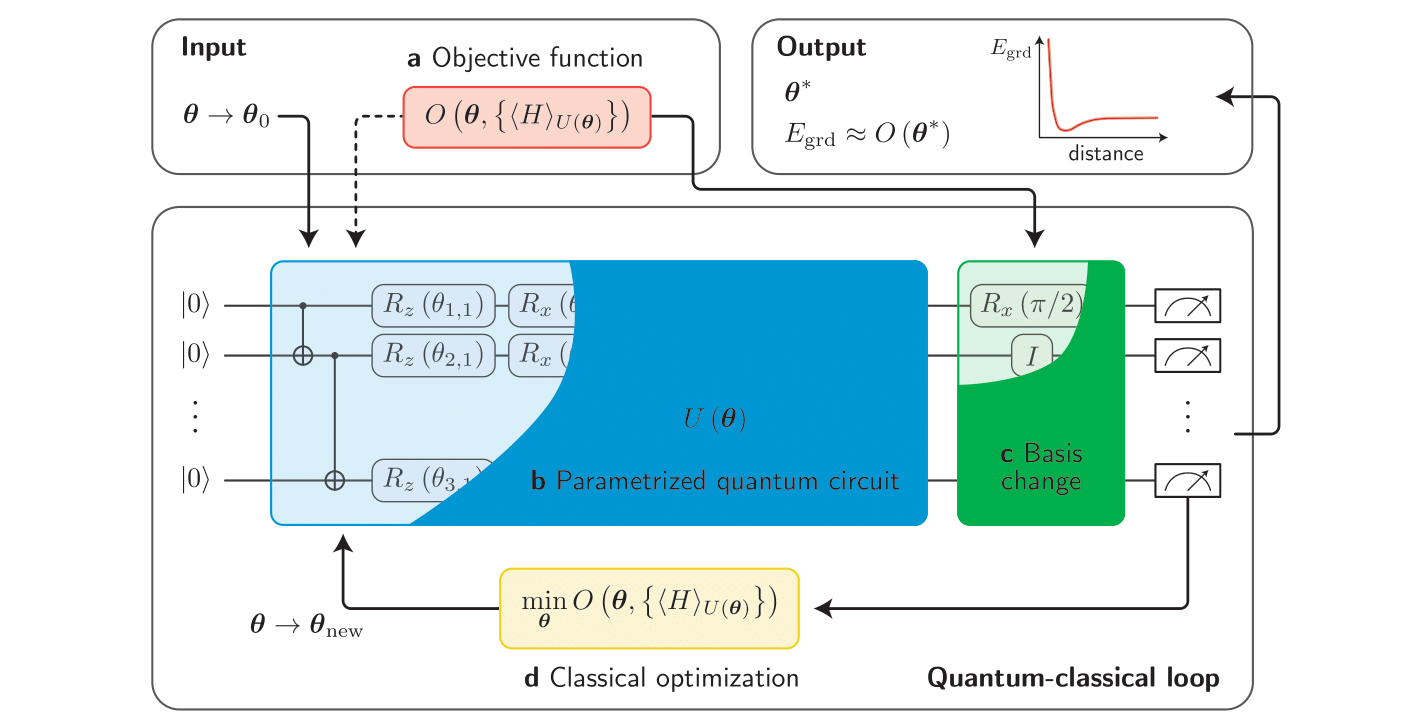)

Source: [Noisy intermediate-scale quantum (NISQ) algorithms (2022)](https://arxiv.org/abs/2101.08448)

## Variational Quantum Eigensolver

The **Variational Quantum Eigensolver** (VQE) is the most widely known variational quantum algorithm, being first proposed by [Peruzzo (2014)](https://arxiv.org/abs/1304.3061). Its motivation follows directly from the variacional principle: the main goal is, given a Hamiltonian (more generally, an hermitian matrix), find the groundstate (i.e. smallest eigenstate). The premier use case example of VQE is in quantum chemistry, as many properties of a molecule can be studied upon knowing the minimum energy level (i.e. eigenvalue) and groundstate of its Hamiltonian.

As an example, let us consider then the (qubit) Hamiltonian of the $H_2$ molecule at bond distance ([Kandala et.al](https://arxiv.org/pdf/1704.05018)), given by:

$$
H_2 = 0.011280 ZZ + 0.397936 ZI + 0.397936 IZ + 0.180931 XX.
$$

First, we use the `SparsePauliOp` class to construct the Hamiltonian.

In [10]:
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp(["ZZ", "IZ", "ZI", "XX"], coeffs=[0.011280, 0.397936, 0.397936, 0.180931])

n = hamiltonian.num_qubits
print(f'Number of qubits: {n}')

Number of qubits: 2


As this is a simple four-by-four matrix, it is possible to calculate the eigenvalue of the Hamiltonian directly using using `numpy.linalg.eigvals`. We will use this value to compare with the results obtained with our VQE implementation.

Observation: This calculations can only be done classically for **small** matrices, i.e. for molecules of low number of qubits. (Otherwise why bother using quantum computers, right?)

In [11]:
import numpy as np

# Get the Hamiltonian matrix and compute its eigenvalues
matrix_hamiltonian = hamiltonian.to_matrix()
eigenvalues = np.linalg.eigvals(matrix_hamiltonian)

exact_eigenvalue = np.min(eigenvalues).real
print(f'Exact eigenvalue: {exact_eigenvalue}')

Exact eigenvalue: -0.8048990656130552


Next, we specify our ansatz. We will consider the `EfficientSU2` [ansatz](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.efficient_su2) mentioned in earlier Notebooks. To compare how differences within the ansatz can influence the end results of the VQE algorithm, we will consider circuits with different gate types and different amount of layers. 

In [12]:
from qiskit.circuit.library import efficient_su2

ansatz1 = efficient_su2(num_qubits = n, su2_gates=["rx"], reps=1)
ansatz2 = efficient_su2(num_qubits = n, su2_gates=["rx", "ry"], reps=2)

num_params_1 = ansatz1.num_parameters
num_params_2 = ansatz2.num_parameters

print(f'Number of parameters ansatz 1: {num_params_1}')
print(f'Number of parameters ansatz 2: {num_params_2}')

Number of parameters ansatz 1: 4
Number of parameters ansatz 2: 12


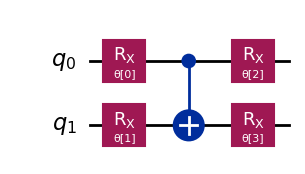

In [13]:
ansatz1.draw('mpl')

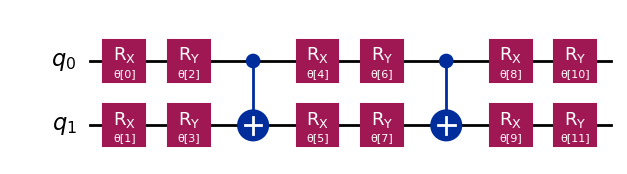

In [14]:
ansatz2.draw('mpl')

Let us consider as backend the Fake device `FakeOslo`. Before defining the cost function, our ansatz has to be converted into an ISA circuit that can be executed in this backend.

In [16]:
from qiskit_ibm_runtime.fake_provider import FakeOslo
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

device = FakeOslo()
pm = generate_preset_pass_manager(backend=device, optimization_level=3)

ansatz_isa1 = pm.run(ansatz1)
ansatz_isa2 = pm.run(ansatz2)

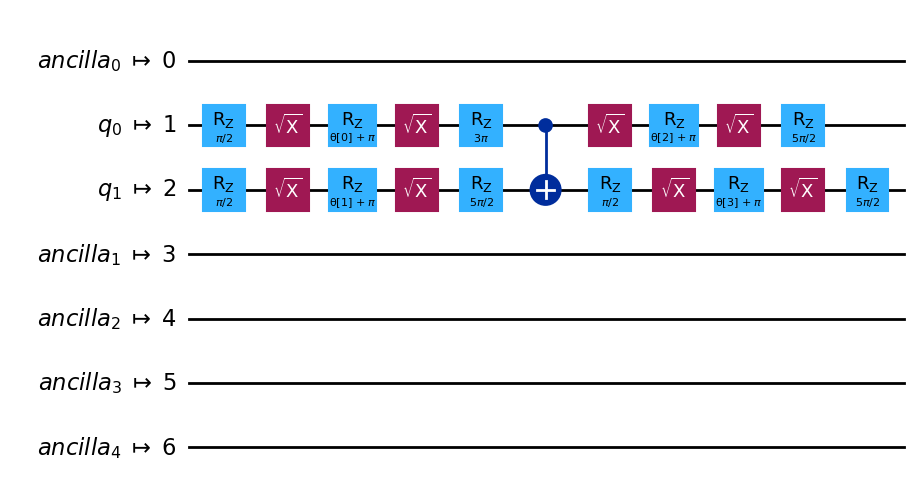

In [17]:
ansatz_isa1.draw('mpl')

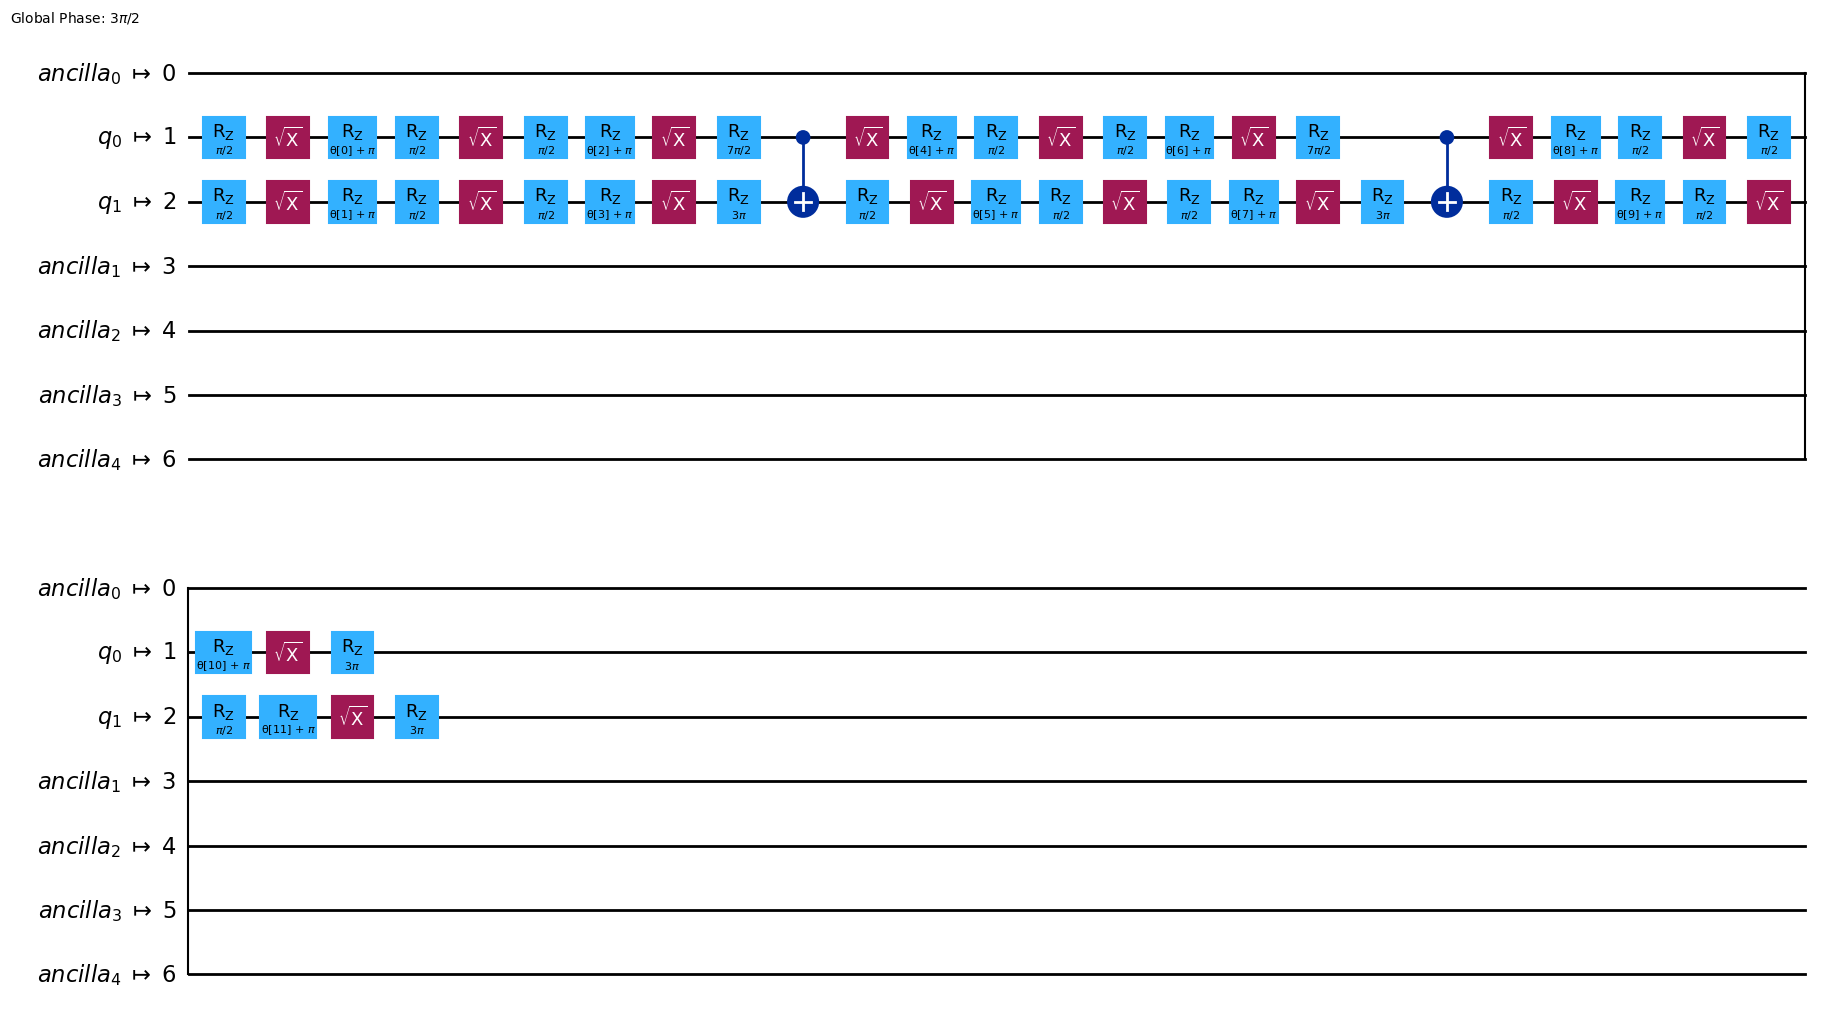

In [18]:
ansatz_isa2.draw('mpl')

The `FakeOslo` backend corresponds to a seven qubit device, whereas our target Hamiltonian has only two qubits. Therefore, we have to make it backend-compatible before running the Estimator. This transformation is perform through the `apply_layout` method of `SparsePauliOp` object.

In [19]:
hamiltonian_isa1 = hamiltonian.apply_layout(layout=ansatz_isa1.layout)
hamiltonian_isa2 = hamiltonian.apply_layout(layout=ansatz_isa2.layout)

print(hamiltonian_isa1)

SparsePauliOp(['IIIIZZI', 'IIIIIZI', 'IIIIZII', 'IIIIXXI'],
              coeffs=[0.01128 +0.j, 0.397936+0.j, 0.397936+0.j, 0.180931+0.j])


Next, we define the cost function through the Estimator class. In addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function, such as the `cost_history_dict`. This dictionary stores the current vector at each iteration, for example in case you need to restart the routine due to failure, and also returns the current iteration number and average time per iteration.

In [20]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    # The following lines are used to keep track of the cost function history

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

# Auxiliary dictionary to track the cost function history

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

Finally, we define our classical optimization method and initial parameters. In this case, we will consider the gradient-free `COBYLA` method from `scipy.optimize`, together with random initial parameters. 

In [21]:
# Define random initial parameters
ini_params_1 = 2 * np.pi *np.random.rand(num_params_1)
ini_params_2 = 2 * np.pi *np.random.rand(num_params_2)

print(ini_params_1)
print(ini_params_2)

[0.84421938 2.34557506 5.8012669  1.49592153]
[5.8334983  2.73898975 4.77702519 3.08094583 2.95878727 3.49899385
 4.93438791 3.19622427 5.47851587 0.96909795 3.04089266 0.79717827]


We will execute the VQE algorithm using the Estimator from Qiskit Aer, without and with the noise model associated to the `FakeOslo` backend.

In [22]:
from qiskit_aer.primitives import EstimatorV2 as EstimatorAer
from scipy.optimize import minimize
from qiskit_aer.noise import NoiseModel

exact_estimator = EstimatorAer()

noise_model = NoiseModel.from_backend(device)
print(noise_model)

options = dict(backend_options=dict(noise_model=noise_model), run_options=dict(seed_estimator=100))     # fix seed for reproducibility
noisy_estimator = EstimatorAer(options=options)

NoiseModel:
  Basis gates: ['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'x', 'sx', 'reset', 'id', 'cx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6]
  Specific qubit errors: [('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('x', (5,)), ('x', (6,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('sx', (5,)), ('sx', (6,)), ('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('cx', (0, 1)), ('cx', (1, 0)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 1)), ('cx', (3, 1)), ('cx', (3, 5)), ('cx', (4, 5)), ('cx', (5, 3)), ('cx', (5, 4)), ('cx', (5, 6)), ('cx', (6, 5)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,)), ('measure', (5,)), ('measure', (6,))]


### Noiseless VQE

In [23]:
res1 = minimize(
    cost_func,                                                      # Cost function
    ini_params_1,                                                   # Initial parameters
    args=(ansatz_isa1, hamiltonian_isa1, exact_estimator),          # Arguments for the cost function
    method="cobyla",                                                # Optimization method
)

Iters. done: 1 [Current cost: 0.024395251471648706]
Iters. done: 2 [Current cost: -0.02066925037133825]
Iters. done: 3 [Current cost: -0.1077637458059823]
Iters. done: 4 [Current cost: -0.10592603148173371]
Iters. done: 5 [Current cost: -0.1833218859633499]
Iters. done: 6 [Current cost: -0.3541489395083115]
Iters. done: 7 [Current cost: -0.31569394991581673]
Iters. done: 8 [Current cost: -0.012428954420788054]
Iters. done: 9 [Current cost: -0.3332274919883971]
Iters. done: 10 [Current cost: -0.2666008530704883]
Iters. done: 11 [Current cost: -0.4655240459362886]
Iters. done: 12 [Current cost: -0.5633749668919956]
Iters. done: 13 [Current cost: -0.6275883638319245]
Iters. done: 14 [Current cost: -0.6089469588198176]
Iters. done: 15 [Current cost: -0.6695852617629158]
Iters. done: 16 [Current cost: -0.7366770738148065]
Iters. done: 17 [Current cost: -0.7762862881397633]
Iters. done: 18 [Current cost: -0.7700471708648251]
Iters. done: 19 [Current cost: -0.7737807645285935]
Iters. done: 20

In [24]:
# Save the results from the auxiliary dictionary

cost_history_dict_1 = cost_history_dict.copy()

res1

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.7845919991049514
       x: [ 3.142e+00  3.612e+00  6.283e+00  2.672e+00]
    nfev: 68
   maxcv: 0.0

In [25]:
# Calculate the relative error of our VQE final result for the ansatz 1

rel_error1 = abs(res1.fun - exact_eigenvalue) / abs(exact_eigenvalue)
print(f"Relative error ansatz 1: {rel_error1}")

Relative error ansatz 1: 0.025229332938331718


In [26]:
# Reset the cost history dictionary

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

res2 = minimize(
    cost_func,                                                     # Cost function
    ini_params_2,                                                   # Initial parameters
    args=(ansatz_isa2, hamiltonian_isa2, exact_estimator),                # Arguments for the cost function
    method="cobyla",                                                # Optimization method
)

Iters. done: 1 [Current cost: 0.10181163238031408]
Iters. done: 2 [Current cost: -0.11485148207142404]
Iters. done: 3 [Current cost: -0.014924632191107623]
Iters. done: 4 [Current cost: -0.20361689738791103]
Iters. done: 5 [Current cost: 0.13811997452024924]
Iters. done: 6 [Current cost: -0.1687539221894853]
Iters. done: 7 [Current cost: -0.3394287716503699]
Iters. done: 8 [Current cost: -0.2110846122172503]
Iters. done: 9 [Current cost: -0.386427675518437]
Iters. done: 10 [Current cost: -0.16291195560925628]
Iters. done: 11 [Current cost: -0.20910711038259827]
Iters. done: 12 [Current cost: -0.3806544651124846]
Iters. done: 13 [Current cost: -0.06329609173527881]
Iters. done: 14 [Current cost: -0.4620691571708104]
Iters. done: 15 [Current cost: -0.2613566951545827]
Iters. done: 16 [Current cost: -0.4726834148809889]
Iters. done: 17 [Current cost: -0.3372366213315678]
Iters. done: 18 [Current cost: -0.4420035131185525]
Iters. done: 19 [Current cost: -0.6189292983089152]
Iters. done: 20

In [27]:
# Save the results from the auxiliary dictionary

cost_history_dict_2 = cost_history_dict.copy()

res2

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.8048990637075047
       x: [ 6.678e+00  3.016e+00  4.641e+00  2.501e+00  3.468e+00
            5.100e+00  5.040e+00  4.320e+00  5.271e+00  4.404e-01
            3.246e+00  2.619e-01]
    nfev: 208
   maxcv: 0.0

In [28]:
rel_error2 = abs(res2.fun - exact_eigenvalue) / abs(exact_eigenvalue)

print(f"Relative error ansatz 2: {rel_error2}")

Relative error ansatz 2: 2.367440312186649e-09


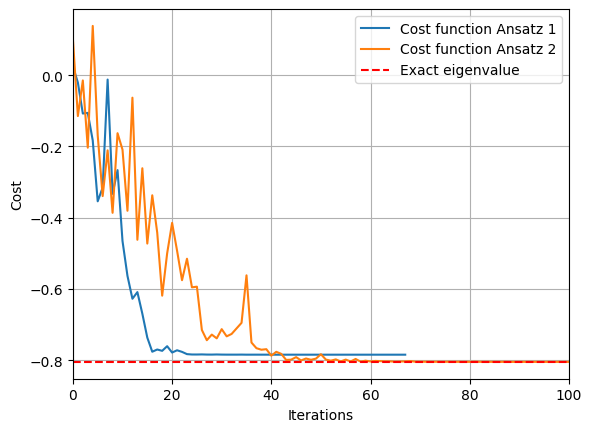

In [30]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(range(cost_history_dict_1["iters"]), cost_history_dict_1["cost_history"], label="Cost function Ansatz 1")
ax.plot(range(cost_history_dict_2["iters"]), cost_history_dict_2["cost_history"], label="Cost function Ansatz 2")
ax.plot(exact_eigenvalue * np.ones(cost_history_dict_2["iters"]), "r--", label="Exact eigenvalue")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.set_xlim(0, 100)
plt.grid()
plt.legend()
plt.draw()

### Noisy VQE

In [31]:
# Reset the cost history dictionary

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

res1_noisy = minimize(
    cost_func,                                                      # Cost function
    ini_params_1,                                                   # Initial parameters
    args=(ansatz_isa1, hamiltonian_isa1, noisy_estimator),          # Arguments for the cost function
    method="cobyla",                                                # Optimization method
    options={"maxiter": 300},                                       # Set max iterations 
)

Iters. done: 1 [Current cost: 0.02609570919475575]
Iters. done: 2 [Current cost: -0.019928205615980715]
Iters. done: 3 [Current cost: -0.10601094556545161]
Iters. done: 4 [Current cost: -0.10425439788076653]
Iters. done: 5 [Current cost: -0.18147225430686967]
Iters. done: 6 [Current cost: -0.3566033964256534]
Iters. done: 7 [Current cost: -0.32995576089530215]
Iters. done: 8 [Current cost: -0.024203201654704274]
Iters. done: 9 [Current cost: -0.3364713839434683]
Iters. done: 10 [Current cost: -0.2692601677781699]
Iters. done: 11 [Current cost: -0.46695058148446417]
Iters. done: 12 [Current cost: -0.5634608053230098]
Iters. done: 13 [Current cost: -0.6265499414789388]
Iters. done: 14 [Current cost: -0.6095938797337414]
Iters. done: 15 [Current cost: -0.6682351977765172]
Iters. done: 16 [Current cost: -0.732643670908648]
Iters. done: 17 [Current cost: -0.7710440035991932]
Iters. done: 18 [Current cost: -0.7635264255937355]
Iters. done: 19 [Current cost: -0.768743645456072]
Iters. done: 2

In [32]:
# Save the results from the auxiliary dictionary

cost_history_dict_noisy_1 = cost_history_dict.copy()

res1_noisy

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.77896326185018
       x: [ 3.142e+00  3.477e+00  6.283e+00  2.806e+00]
    nfev: 300
   maxcv: 0.0

In [33]:
rel_error_noisy1 = abs(res1_noisy.fun - exact_eigenvalue) / abs(exact_eigenvalue)

print(f"Relative error ansatz 1: {rel_error1}")
print(f"Relative error ansatz 1 with noise: {rel_error_noisy1}")

Relative error ansatz 1: 0.025229332938331718
Relative error ansatz 1 with noise: 0.03222242995538957


In [34]:
# Reset the cost history dictionary

cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

res2_noisy = minimize(
    cost_func,                                                      # Cost function
    ini_params_2,                                                   # Initial parameters
    args=(ansatz_isa2, hamiltonian_isa2, noisy_estimator),          # Arguments for the cost function
    method="cobyla",                                                # Optimization method
    options={"maxiter": 300}                                       # Set max iterations
)

Iters. done: 1 [Current cost: 0.09668849332223195]
Iters. done: 2 [Current cost: -0.11400001271035447]
Iters. done: 3 [Current cost: -0.015590907127624287]
Iters. done: 4 [Current cost: -0.1994021896865999]
Iters. done: 5 [Current cost: 0.1360288444074823]
Iters. done: 6 [Current cost: -0.16542300605339982]
Iters. done: 7 [Current cost: -0.3310344334851129]
Iters. done: 8 [Current cost: -0.20487403567147064]
Iters. done: 9 [Current cost: -0.37579128679060214]
Iters. done: 10 [Current cost: -0.15933783226878484]
Iters. done: 11 [Current cost: -0.20317411401304536]
Iters. done: 12 [Current cost: -0.3702998596698245]
Iters. done: 13 [Current cost: -0.06012447478203981]
Iters. done: 14 [Current cost: -0.45077392541127564]
Iters. done: 15 [Current cost: -0.2559881484858357]
Iters. done: 16 [Current cost: -0.46126930631680885]
Iters. done: 17 [Current cost: -0.3274316874788595]
Iters. done: 18 [Current cost: -0.4322486019843029]
Iters. done: 19 [Current cost: -0.6034708681243158]
Iters. done

In [35]:
# Save the results from the auxiliary dictionary

cost_history_dict_noisy_2 = cost_history_dict.copy()

res2_noisy

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.7839672192839191
       x: [ 6.673e+00  3.067e+00  4.573e+00  2.380e+00  3.372e+00
            5.142e+00  5.067e+00  4.276e+00  5.403e+00  4.169e-01
            3.277e+00  3.508e-01]
    nfev: 300
   maxcv: 0.0

In [36]:
rel_error_noisy2 = abs(res2_noisy.fun - exact_eigenvalue) / abs(exact_eigenvalue)

print(f"Relative error ansatz 2: {rel_error2}")
print(f"Relative error ansatz 2 with noise: {rel_error_noisy2}")

Relative error ansatz 2: 2.367440312186649e-09
Relative error ansatz 2 with noise: 0.026005554265606332


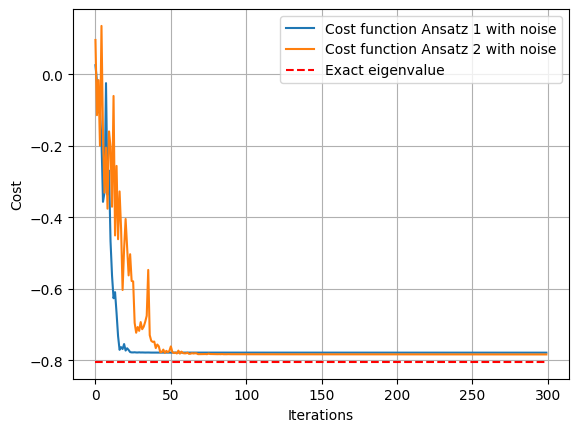

In [37]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict_noisy_1["iters"]), cost_history_dict_noisy_1["cost_history"], label="Cost function Ansatz 1 with noise")
ax.plot(range(cost_history_dict_noisy_2["iters"]), cost_history_dict_noisy_2["cost_history"], label="Cost function Ansatz 2 with noise")
ax.plot(exact_eigenvalue * np.ones(cost_history_dict_noisy_2["iters"]), "r--", label="Exact eigenvalue")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.grid()
plt.legend()
plt.draw()

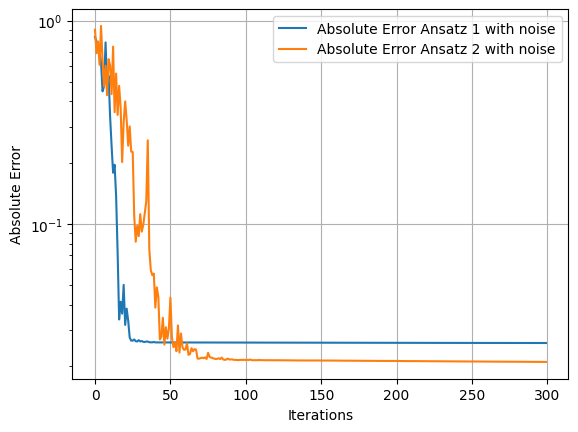

In [38]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict_noisy_1["iters"]), np.abs(cost_history_dict_noisy_1["cost_history"]-exact_eigenvalue), label="Absolute Error Ansatz 1 with noise")
ax.plot(range(cost_history_dict_noisy_2["iters"]), np.abs(cost_history_dict_noisy_2["cost_history"]-exact_eigenvalue), label="Absolute Error Ansatz 2 with noise")
ax.set_xlabel("Iterations")
ax.set_ylabel("Absolute Error")
ax.set_yscale("log")
plt.grid()
plt.legend()
plt.draw()